<img src="Conf_Ellipse.png" width="450" height="300" align="right"/>

# K_Means: Confidence Ellipses
  
Author: Christoph Güttner  

A datasets that has the form of two elliptic clusters is labeled by  
the k_means algorithm with different distance metrics. First, the  
Euclidean distance ($l_2$ metric) is used, which, however, assumes  
spherical (uncorrelated) clusters. Second, k_means is applied based  
on the Mahalonobis distance, which takes account for the covariance of  
the data.(For more information about the K_Means_Mahalanobis_Classifier  
see: https://github.com/cmgsouza)  
  
For both of the resulting clusters (and for the raw data) the 95%  
confidence ellipses are calculated and drawn. Here, the Cholesky   
factor $L$ (lower bound) of the clusters covariance matrices with  
$\Sigma= L \cdot L^T$ is used to transfer the coveriance towards initally uncorrelated     
set of polar variables (Circle).   

$\mathbf{x}(\theta)=
\boldsymbol{\mu} + \sqrt{\chi^2}\mathbf{L}
\left[
\begin{matrix}
\cos(\theta)\\
\sin(\theta)
\end{matrix}
\right]$  

That brings the advantage that the resulting ellipses (correlated variables    
with the same covariance as the original ellipses) can easily be scaled by  
the square root of the $\chi^2$ statistic (and positioned by the cluster's mean).   
Note, that the squared Mahalanobis distance aLso follows the $\chi^2$  
statistic.   

However, there also exists other ways to construct the covariance ellipse.  
In general, the normalised covariance ellipse has the following normal form:
  
$(\frac{e_1^T x}{\sigma_1})^2+ (\frac{e_2^T x}{\sigma_2})^2=1$  
   
whereby $e_1$ and $e_2$ describe the eigenvectors of the clusters  
covaricance matrix and the orthogonal axes of the covariance ellipses (maximum  
variance).  
Last, the resulting clusters are evaluated by the silhouette score.





## Table of Contents
* [Loading and Preprocessing](#Loading_and_Preprocessing)
    * [Imports](#Imports)
    * [Functions](#Functions)
* [Data](#Data)
    * [Cluster Ellipse](#Cluster_Ellipse)
    * [Confindence Ellipse](#Confindence_Ellipse)
* [K_Means_Euclidean](#K_Means_Euclidean)
    * [Confindence Ellipse](#Confindence_Ellipse)
    * [Cluster Ellipse](#Cluster_Ellipse)
* [K_Means_Mahalanobis](#K_Means_Mahalanobis)
    * [Confindence Ellipse](#Confindence_Ellipse)
    * [Cluster Ellipse](#Cluster_Ellipse)
* [Evaluation by Silhouette Score](#Evaluation_by_Silhouette_Score)
    * [Ellipse](#Ellipse)

In [419]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy import linalg
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn import metrics
from cmgsouza import KMeansMahalanobisClassifier



In [420]:

def get_Ellipse(n_samples, dependency, exp):
    x=np.random.normal(exp[0],0.5,n_samples)
    y=np.random.normal(exp[1],0.5,n_samples)
    noise= np.array([x,y])
    ellipse_transposed = np.dot(noise.T, dependency)
    ellipse = ellipse_transposed.T
    mean =np.mean(ellipse, axis = 1)
    return ellipse, mean

def join_data(data):
    ellipses = np.hstack(data)
    return ellipses

def get_Euclidean(a,b):
    Euclid = sum((a-b)**2)**(1/2)
    return Euclid

def get_error_ellipse(data, chi):
    covM, InvCovM = get_covariance(data)
    L = linalg.cholesky(covM, lower=True)
    mean_x,mean_y =np.mean(data, axis = 1)
    X1, X2 = [],[]
    for i,k in enumerate(np.linspace(0,2*np.pi, 150)):
        ellipse = np.array([mean_x,mean_y]) + chi *L @ np.array([np.cos(k), np.sin(k)])
        X1.append(ellipse[0])
        X2.append(ellipse[1])
    return X1,X2

def get_covariance(data):
    covM = np.cov(data, bias = False) # To get the covariance matrix
    invCoveM = np.linalg.inv(covM) # To get the inverse covariance matrix
    return covM, invCoveM

def get_Mahalanobis(mean, invCoveM, point):
    xMm = point - mean
    tem1 = np.dot(xMm,invCoveM)
    tem2 = np.dot(tem1, np.transpose(xMm))
    MD = np.sqrt(tem2)
    return MD

def plot_data(data, labels, title, color):
    plt.figure(figsize=(8,8))
    if isinstance(labels, np.ndarray):
        for i,label in enumerate(labels):
            plt.scatter(data[0][i],data[1][i], color=color[label], s=4)
    else:  
        plt.scatter(data[0], data[1], label='data', s=4)
    #plt.plot(mean[0],mean[1], '*', color='r')
    plt.title(title, fontdict = {'fontsize' : 30})
    #plt.legend()

def separate_clusters(data, labels):
    First_X, First_Y =[],[]
    Second_X, Second_Y =[],[]
    for i,label in enumerate(labels):
        if label==0:
            First_X.append(data[0][i])
            First_Y.append(data[1][i])
        elif label==1:
            Second_X.append(data[0][i])
            Second_Y.append(data[1][i])
        else:
            print('error')
    return First_X, First_Y, Second_X, Second_Y


def plot_Silhouette(evalu_euclid,evalu_mahalanobis):
    dict = {'K_Means_Euclid':evalu_euclid, 'K_Means_Mahalanaobis':evalu_mahalanobis}
    df = pd.DataFrame(dict, index=['Score'])
    df.plot.bar(figsize=(15,5))
    plt.title('Evaluation by Silhouette Score')
    plt.show()


## Global Variables

In [421]:

n_samples = 1000
dependency = [[0.2, 0.8], [0.6, 0.8]] 
chi = np.sqrt(5.99) 
color=['#FD814E','#849271']


## Correlated Dataset: Ellipse

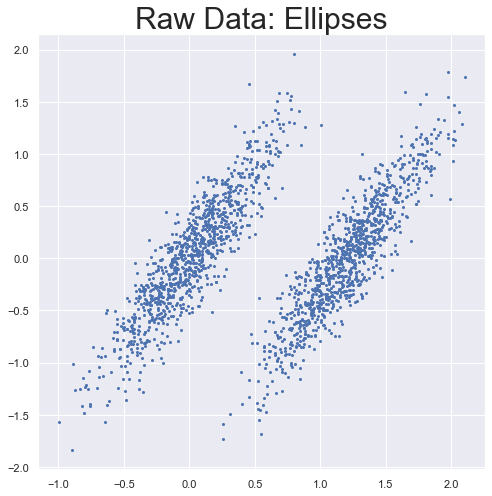

In [422]:
np.random.seed(1)
labels_raw = [2]*n_samples *2
ellipse1, mean1 = get_Ellipse(n_samples, dependency, [0,0])
ellipse2, mean2 = get_Ellipse(n_samples, dependency, [-3,3])



ellipse = join_data((ellipse1,ellipse2))

title = 'Raw Data: Ellipses'
plot_data(ellipse, label_raw, title, color)

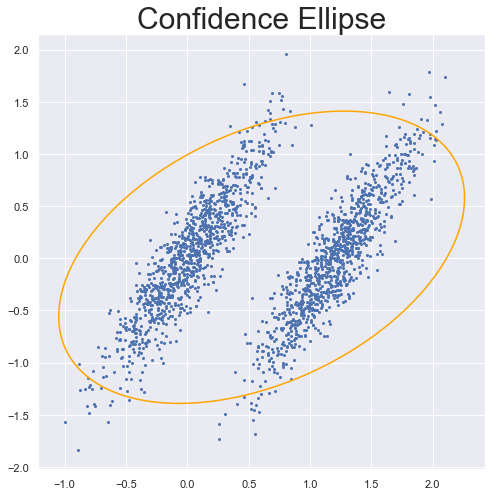

In [423]:
error_ellipse =   get_error_ellipse(ellipse, chi)
title = 'Confidence Ellipse'
plot_data(ellipse,label_raw, title, color)
plt.plot(error_ellipse[0],error_ellipse[1], color='orange')
plt.show()


## K_Means_with Euclidean Distance

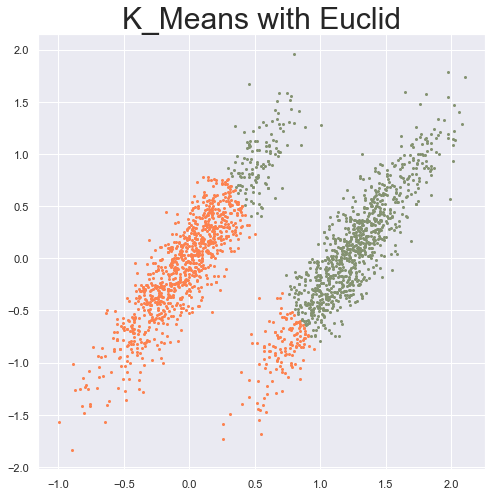

In [424]:
kmeans = KMeans(n_clusters=2,random_state=0).fit(ellipse.T)
center = kmeans.cluster_centers_
pred=kmeans.predict(ellipse.T) 
labels= kmeans.labels_



title='K_Means with Euclid'

plot_data(ellipse,labels, title, color)

In [425]:
EuFirst_X, EuFirst_Y, EuSecond_X, EuSecond_Y = separate_clusters(ellipse, labels)

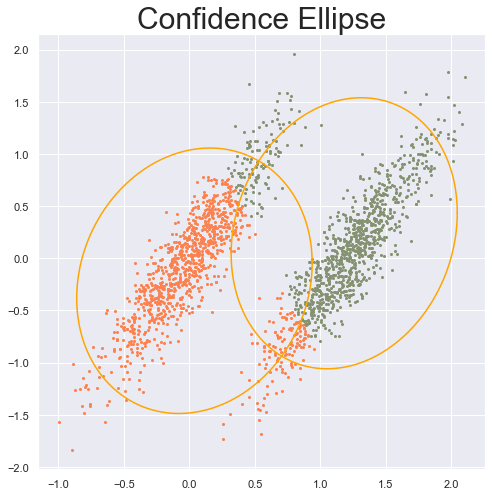

In [426]:
# Confidence Ellipse for first(f) and second(s) cluster

EuX1_f,EuX2_f =   get_error_ellipse((EuFirst_X, EuFirst_Y), chi)
EuX1_s,EuX2_s =   get_error_ellipse((EuSecond_X, EuSecond_Y), chi)
title = 'Confidence Ellipse'
plot_data(ellipse, labels, title, color)
plt.plot(EuX1_f,EuX2_f, color='orange')
plt.plot(EuX1_s,EuX2_s, color='orange')
plt.show()

## K-Means with Mahalanobis distance

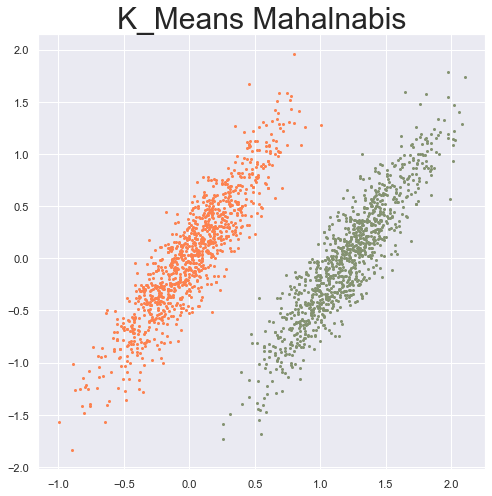

In [427]:

kmeans_mahalanobis = KMeansMahalanobisClassifier(2)
y_kmeans_mahalanobis = kmeans_mahalanobis.fit(ellipse.T).predict(ellipse.T)
title= 'K_Means Mahalnabis'

plot_data(ellipse,y_kmeans_mahalanobis,title, color )

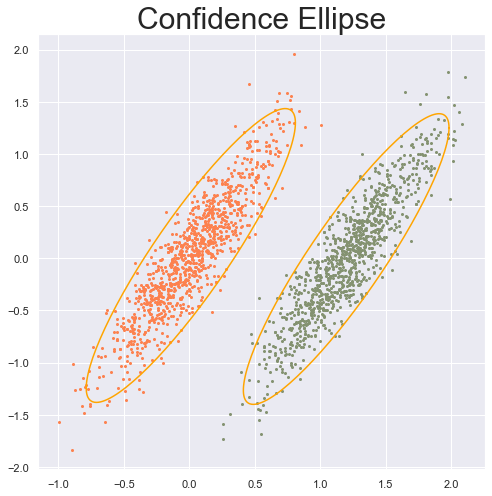

In [428]:
MFirst_X, MFirst_Y, MSecond_X, MSecond_Y = separate_clusters(ellipse, y_kmeans_mahalanobis)

MX1_f,MX2_f =   get_error_ellipse((MFirst_X, MFirst_Y), chi)
MX1_s,MX2_s =   get_error_ellipse((MSecond_X, MSecond_Y), chi)
#ellipse, mean = get_Ellipse(n_samples, dependency)
title = 'Confidence Ellipse'
plot_data(ellipse, y_kmeans_mahalanobis, title, color)
plt.plot(MX1_f,MX2_f, color='orange')
plt.plot(MX1_s,MX2_s, color='orange')
plt.show()

## Combined Confidence

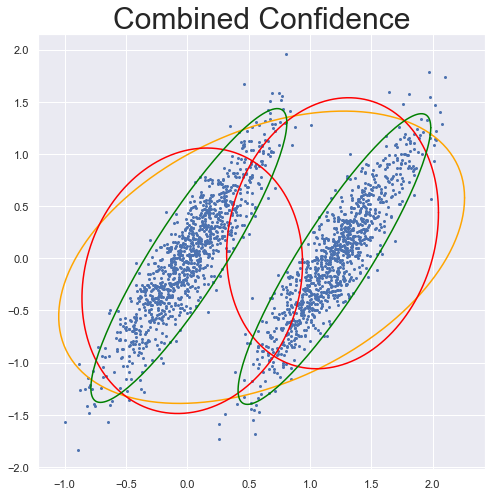

In [429]:
title = 'Combined Confidence'
plot_data(ellipse,'none', title, color)
plt.plot(error_ellipse[0],error_ellipse[1], color='orange')
plt.plot(EuX1_f,EuX2_f, color='red')
plt.plot(EuX1_s,EuX2_s, color='red')
plt.plot(MX1_f,MX2_f, color='green')
plt.plot(MX1_s,MX2_s, color='green')
plt.show()

## Evaluation by Silhouette Score



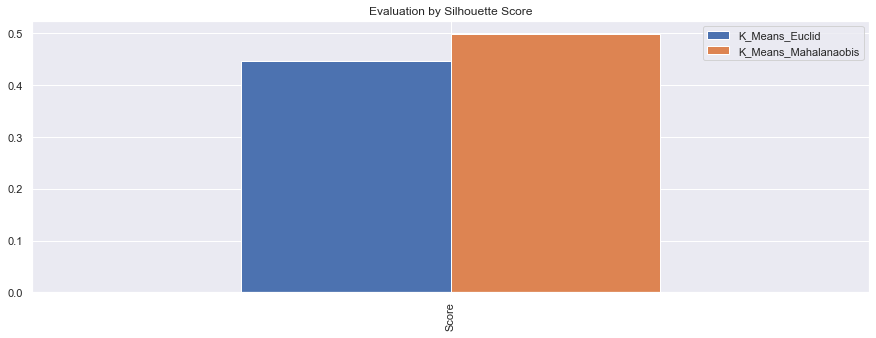

In [430]:
evalu_euclid = metrics.silhouette_score(ellipse.T, labels, metric='euclidean')
evalu_mahalanobis= metrics.silhouette_score(ellipse.T, y_kmeans_mahalanobis, metric='mahalanobis')


plot_Silhouette(evalu_euclid,evalu_mahalanobis)
